In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.metrics import log_loss
from sklearn.model_selection import StratifiedKFold
import gc
import os
import matplotlib.pyplot as plt
import seaborn as sns 
import lightgbm as lgb
import itertools
import pickle, gzip
import glob
import importlib
import time

from joblib import dump, load

from cv_sampler import *

np.warnings.filterwarnings('ignore')



In [2]:
import load_data
importlib.reload(load_data)

<module 'load_data' from '/home/matsui-k/projects/kaggle-lsst/scripts/load_data.py'>

In [27]:
gal_df, ex_df, gal_target, ex_target = load_data.load_train()
gal_class_weight, gal_sample_weights, gal_target_i = load_data.get_weights(gal_target)

In [4]:
gal_clf = load('../models/gal_clf12081220.joblib')

In [5]:
ex_clf = load('../models/ex_clf12081220.joblib')

In [6]:
sample_sub = pd.read_csv('../input/sample_submission.csv')

In [111]:
sample_sub.columns

Index(['object_id', 'class_6', 'class_15', 'class_16', 'class_42', 'class_52',
       'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88',
       'class_90', 'class_92', 'class_95', 'class_99'],
      dtype='object')

In [112]:
sample_sub

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0               13        0         0         0         0         0         0   
1               14        0         0         0         0         0         0   
2               17        0         0         0         0         0         0   
3               23        0         0         0         0         0         0   
4               34        0         0         0         0         0         0   
5               35        0         0         0         0         0         0   
6               43        0         0         0         0         0         0   
7               50        0         0         0         0         0         0   
8               60        0         0         0         0         0         0   
9               69        0         0         0         0         0         0   
10              88        0         0         0         0         0         0   
11              96        0         0         0         0         0         0   
12             106        0         0         0         0         0         0   
13             114        0         0         0         0         0         0   
14             115        0         0         0         0         0         0   
15             116        0         0         0         0         0         0   
16             130        0         0         0         0         0         0   
17             142        0         0         0         0         0         0   
18             147        0         0         0         0         0         0   
19             151        0         0         0         0         0         0   
20             168        0         0         0         0         0         0   
21             171        0         0         0         0         0         0   
22             173        0         0         0         0         0         0   
23             176        0         0         0         0         0         0   
24             184        0         0         0         0         0         0   
25             186        0         0         0         0         0         0   
26             195        0         0         0         0         0         0   
27             198        0         0         0         0         0         0   
28             204        0         0         0         0         0         0   
29             211        0         0         0         0         0         0   
...            ...      ...       ...       ...       ...       ...       ...   
3492860  130787078        0         0         0         0         0         0   
3492861  130787121        0         0         0         0         0         0   
3492862  130787259        0         0         0         0         0         0   
3492863  130787288        0         0         0         0         0         0   
3492864  130787315        0         0         0         0         0         0   
3492865  130787346        0         0         0         0         0         0   
3492866  130787409        0         0         0         0         0         0   
3492867  130787413        0         0         0         0         0         0   
3492868  130787553        0         0         0         0         0         0   
3492869  130787572        0         0         0         0         0         0   
3492870  130787650        0         0         0         0         0         0   
3492871  130787683        0         0         0         0         0         0   
3492872  130787746        0         0         0         0         0         0   
3492873  130787754        0         0         0         0         0         0   
3492874  130787792        0         0         0         0         0         0   
3492875  130787808        0         0         0         0         0         0   
3492876  130787817        0         0         0         0         0         0   
3492877  130787819        0         0   

In [44]:
pred_proba = gal_clf.predict_proba(gal_df)

classes = sorted(gal_target.unique())
classes

[6, 16, 53, 65, 92]

In [16]:
proba_df = pd.DataFrame(columns=['object_id', 'class_6', 'class_15', 'class_16', 'class_42', 'class_52',
       'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88',
       'class_90', 'class_92', 'class_95', 'class_99'])

In [17]:
for i in range(5):
    proba_df[f'class_{classes[i]}'] = pred_proba[:, i]

In [18]:
proba_df['object_id'] = gal_df.index

In [21]:
proba_df.fillna(0, inplace=True)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f143f3446a0>,
      dtype=object)

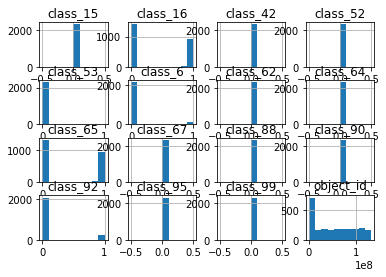

In [23]:
proba_df.hist()

In [41]:
pred_proba = ex_clf.predict_proba(ex_df)

classes = sorted(ex_target.unique())

In [31]:
ex_proba_df = pd.DataFrame(columns=['object_id', 'class_6', 'class_15', 'class_16', 'class_42', 'class_52',
       'class_53', 'class_62', 'class_64', 'class_65', 'class_67', 'class_88',
       'class_90', 'class_92', 'class_95', 'class_99'])

In [42]:
classes

[15, 42, 52, 62, 64, 67, 88, 90, 95]

In [32]:
for i in range(5):
    ex_proba_df[f'class_{classes[i]}'] = pred_proba[:, i]

In [33]:
ex_proba_df['object_id'] = ex_df.index

In [34]:
ex_proba_df.fillna(0, inplace=True)

In [37]:
ex_proba_df.hist(figsize=(15, 20))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f140c1c2e48>,
      dtype=object)

In [38]:
ex_proba_df

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0           713        0  0.000504         0  0.000968  0.000501         0   
1           730        0  0.002081         0  0.571762  0.010430         0   
2           745        0  0.003144         0  0.031840  0.059125         0   
3          1124        0  0.002091         0  0.043146  0.098678         0   
4          1598        0  0.006083         0  0.209654  0.019975         0   
5          1632        0  0.002103         0  0.792319  0.017495         0   
6          1920        0  0.006386         0  0.051731  0.109241         0   
7          2072        0  0.003990         0  0.038753  0.019581         0   
8          2103        0  0.009624         0  0.813824  0.049753         0   
9          2300        0  0.000763         0  0.907886  0.010938         0   
10         2330        0  0.002001         0  0.072388  0.042285         0   
11         2922        0  0.000608         0  0.008119  0.006783         0   
12         3041        0  0.000619         0  0.031088  0.006230         0   
13         3285        0  0.005444         0  0.624772  0.130698         0   
14         3423        0  0.000725         0  0.024556  0.003094         0   
15         3489        0  0.000430         0  0.000592  0.000279         0   
16         3910        0  0.001049         0  0.020715  0.005340         0   
17         4088        0  0.000099         0  0.000137  0.000065         0   
18         4132        0  0.005135         0  0.559203  0.063947         0   
19         4173        0  0.951171         0  0.014109  0.002381         0   
20         4220        0  0.009327         0  0.917138  0.006509         0   
21         4389        0  0.007688         0  0.086683  0.108616         0   
22         4595        0  0.004699         0  0.102742  0.044813         0   
23         4819        0  0.002404         0  0.021001  0.015574         0   
24         5527        0  0.003611         0  0.638839  0.006357         0   
25         6180        0  0.000989         0  0.041409  0.031454         0   
26         6762        0  0.001560         0  0.054880  0.091218         0   
27         6947        0  0.003221         0  0.205210  0.063625         0   
28         7033        0  0.009614         0  0.701741  0.045142         0   
29         7164        0  0.002718         0  0.095134  0.074468         0   
...         ...      ...       ...       ...       ...       ...       ...   
5493  129729789        0  0.413013         0  0.117647  0.022574         0   
5494  129759341        0  0.145207         0  0.116950  0.028052         0   
5495  129773611        0  0.012640         0  0.220569  0.026155         0   
5496  129818444        0  0.000827         0  0.000437  0.000126         0   
5497  129828542        0  0.024714         0  0.185085  0.039947         0   
5498  129832862        0  0.009064         0  0.123011  0.043804         0   
5499  129913235        0  0.039420         0  0.151164  0.063033         0   
5500  129999603        0  0.010882         0  0.100524  0.058675         0   
5501  130072052        0  0.000623         0  0.000344  0.000071         0   
5502  130085491        0  0.024268         0  0.042490  0.009698         0   
5503  130088373        0  0.092404         0  0.150648  0.025684         0   
5504  130102752        0  0.033653         0  0.267048  0.074529         0   
5505  130127657        0  0.002180         0  0.001268  0.000315         0   
5506  130188020        0  0.075971         0  0.082583  0.047751         0   
5507  130231675        0  0.039298         0  0.403010  0.070379         0   
5508  130263372        0  0.081047         0  0.090447  0.029399         0   
5509  130319749        0  0.010830         0  0.776632  0.019631         0   
5510  130359176        0  0.015711         0  0.019623  0.870789         0   
5511  130375489        0  0.028864         0  0.194267  0.057035         0   
5512  130402542        0  0.

In [39]:
submit_df = pd.concat([proba_df, ex_proba_df])

In [40]:
submit_df

object_id   class_6  class_15      class_16  class_42  class_52  \
0           615  0.000087  0.000000  1.420804e-03  0.000000  0.000000   
1          1227  0.000153  0.000000  1.830320e-04  0.000000  0.000000   
2          1926  0.000439  0.000000  1.830704e-02  0.000000  0.000000   
3          2624  0.004145  0.000000  1.017093e-06  0.000000  0.000000   
4          2677  0.000060  0.000000  9.988906e-01  0.000000  0.000000   
5          4171  0.000015  0.000000  9.997958e-01  0.000000  0.000000   
6          6266  0.000316  0.000000  1.799916e-06  0.000000  0.000000   
7          7566  0.000025  0.000000  9.988974e-01  0.000000  0.000000   
8          7756  0.000008  0.000000  9.995621e-01  0.000000  0.000000   
9          8688  0.002357  0.000000  2.121407e-06  0.000000  0.000000   
10         8784  0.000052  0.000000  9.998005e-01  0.000000  0.000000   
11         9006  0.001428  0.000000  9.516804e-04  0.000000  0.000000   
12         9172  0.000777  0.000000  4.367392e-06  0.000000  0.000000   
13         9543  0.000252  0.000000  2.830845e-04  0.000000  0.000000   
14         9985  0.004518  0.000000  1.417125e-06  0.000000  0.000000   
15        10349  0.000101  0.000000  1.738807e-06  0.000000  0.000000   
16        10796  0.000802  0.000000  3.802357e-05  0.000000  0.000000   
17        11165  0.000332  0.000000  9.986902e-01  0.000000  0.000000   
18        11931  0.000714  0.000000  1.301711e-05  0.000000  0.000000   
19        12695  0.000070  0.000000  5.294800e-05  0.000000  0.000000   
20        12872  0.001263  0.000000  1.359857e-04  0.000000  0.000000   
21        14080  0.002064  0.000000  3.739423e-06  0.000000  0.000000   
22        14156  0.000366  0.000000  5.056006e-07  0.000000  0.000000   
23        15475  0.005828  0.000000  2.671738e-06  0.000000  0.000000   
24        15626  0.000059  0.000000  9.985838e-01  0.000000  0.000000   
25        15700  0.000112  0.000000  9.998476e-01  0.000000  0.000000   
26        16339  0.000030  0.000000  9.999313e-01  0.000000  0.000000   
27        16349  0.000158  0.000000  9.998392e-01  0.000000  0.000000   
28        17094  0.000019  0.000000  9.999443e-01  0.000000  0.000000   
29        17172  0.000027  0.000000  9.999292e-01  0.000000  0.000000   
...         ...       ...       ...           ...       ...       ...   
5493  129729789  0.000000  0.413013  0.000000e+00  0.117647  0.022574   
5494  129759341  0.000000  0.145207  0.000000e+00  0.116950  0.028052   
5495  129773611  0.000000  0.012640  0.000000e+00  0.220569  0.026155   
5496  129818444  0.000000  0.000827  0.000000e+00  0.000437  0.000126   
5497  129828542  0.000000  0.024714  0.000000e+00  0.185085  0.039947   
5498  129832862  0.000000  0.009064  0.000000e+00  0.123011  0.043804   
5499  129913235  0.000000  0.039420  0.000000e+00  0.151164  0.063033   
5500  129999603  0.000000  0.010882  0.000000e+00  0.100524  0.058675   
5501  130072052  0.000000  0.000623  0.000000e+00  0.000344  0.000071   
5502  130085491  0.000000  0.024268  0.000000e+00  0.042490  0.009698   
5503  130088373  0.000000  0.092404  0.000000e+00  0.150648  0.025684   
5504  130102752  0.000000  0.033653  0.000000e+00  0.267048  0.074529   
5505  130127657  0.000000  0.002180  0.000000e+00  0.001268  0.000315   
5506  130188020  0.000000  0.075971  0.000000e+00  0.082583  0.047751   
5507  130231675  0.000000  0.039298  0.000000e+00  0.403010  0.070379   
5508  130263372  0.000000  0.081047  0.000000e+00  0.090447  0.029399   
5509  130319749  0.000000  0.010830  0.000000e+00  0.776632  0.019631   
5510  130359176  0.000000  0.015711  0.000000e+00  0.019623  0.870789   
5511  130375489  0.000000  0.028864  0.000000e+00  0.194267  0.057035   
5512  130402542  0.000000  0.878663  0.000000e+00  0.030736  0.004214   
5513  130414189  0.000000  0.085270  0.000000e+00  0.173912  0.063837   
5514  130552230  0.000000  0.060087  0.000000e+00  0.484754  0.080023   
5515  130595291  0.000000  0.958111  0.000000e+00  0.025140  0.0

In [135]:
import submit
importlib.reload(submit)

<module 'submit' from '/home/matsui-k/projects/kaggle-lsst/scripts/submit.py'>

In [136]:
subdf = submit.submit_scv(gal_clf, ex_clf, gal_df, ex_df)

In [138]:
submit.write_submit_unknown_onehot(subdf, 'train_result')

In [137]:
unknown_df = subdf.copy()
for i, max_ in enumerate(subdf.drop(columns=['object_id']).max(axis=1)):
    if max_ < 0.4:
        unknown_df.loc[i, 'class_99'] = 1 - max_

onehot_df = pd.DataFrame(0, index=subdf.index, columns=subdf.columns)
for i, key in enumerate(
        unknown_df.drop(columns=['object_id']).idxmax(axis=1)):
    onehot_df.loc[i, key] = 1

KeyboardInterrupt: 

In [132]:
onehot_df

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0             0        0         0         0         0         0         0   
1             0        0         0         0         0         0         0   
2             0        0         0         0         0         0         0   
3             0        0         0         0         0         0         0   
4             0        0         0         1         0         0         0   
5             0        0         0         1         0         0         0   
6             0        0         0         0         0         0         0   
7             0        0         0         1         0         0         0   
8             0        0         0         1         0         0         0   
9             0        0         0         0         0         0         0   
10            0        0         0         1         0         0         0   
11            0        0         0         0         0         0         0   
12            0        0         0         0         0         0         0   
13            0        0         0         0         0         0         0   
14            0        0         0         0         0         0         0   
15            0        0         0         0         0         0         0   
16            0        0         0         0         0         0         0   
17            0        0         0         1         0         0         0   
18            0        0         0         0         0         0         0   
19            0        0         0         0         0         0         0   
20            0        0         0         0         0         0         0   
21            0        0         0         0         0         0         0   
22            0        0         0         0         0         0         0   
23            0        0         0         0         0         0         0   
24            0        0         0         1         0         0         0   
25            0        0         0         1         0         0         0   
26            0        0         0         1         0         0         0   
27            0        0         0         1         0         0         0   
28            0        0         0         1         0         0         0   
29            0        0         0         1         0         0         0   
...         ...      ...       ...       ...       ...       ...       ...   
7818          0        0         0         0         0         0         0   
7819          0        0         0         0         0         0         0   
7820          0        0         0         0         0         0         0   
7821          0        0         0         0         0         0         0   
7822          0        0         0         0         0         0         0   
7823          0        0         0         0         0         0         0   
7824          0        0         0         0         0         0         0   
7825          0        0         0         0         0         0         0   
7826          0        0         0         0         0         0         0   
7827          0        0         0         0         0         0         0   
7828          0        0         0         0         0         0         0   
7829          0        0         0         0         0         0         0   
7830          0        0         0         0         0         0         0   
7831          0        0         0         0         0         0         0   
7832          0        0         0         0         1         0         0   
7833          0        0         0         0         0         0         0   
7834          0        0         0         0         1         0         0   
7835          0        0         0         0         0         1         0   
7836          0        0         0         0         0         0         0   
7837          0        0    

In [130]:
submit.write_submit_unknown_onehot(subdf, 'train_result')

In [103]:
subdf

object_id   class_6  class_15      class_16  class_42  class_52  \
0           615  0.000087  0.000000  1.420804e-03  0.000000  0.000000   
1          1227  0.000153  0.000000  1.830320e-04  0.000000  0.000000   
2          1926  0.000439  0.000000  1.830704e-02  0.000000  0.000000   
3          2624  0.004145  0.000000  1.017093e-06  0.000000  0.000000   
4          2677  0.000060  0.000000  9.988906e-01  0.000000  0.000000   
5          4171  0.000015  0.000000  9.997958e-01  0.000000  0.000000   
6          6266  0.000316  0.000000  1.799916e-06  0.000000  0.000000   
7          7566  0.000025  0.000000  9.988974e-01  0.000000  0.000000   
8          7756  0.000008  0.000000  9.995621e-01  0.000000  0.000000   
9          8688  0.002357  0.000000  2.121407e-06  0.000000  0.000000   
10         8784  0.000052  0.000000  9.998005e-01  0.000000  0.000000   
11         9006  0.001428  0.000000  9.516804e-04  0.000000  0.000000   
12         9172  0.000777  0.000000  4.367392e-06  0.000000  0.000000   
13         9543  0.000252  0.000000  2.830845e-04  0.000000  0.000000   
14         9985  0.004518  0.000000  1.417125e-06  0.000000  0.000000   
15        10349  0.000101  0.000000  1.738807e-06  0.000000  0.000000   
16        10796  0.000802  0.000000  3.802357e-05  0.000000  0.000000   
17        11165  0.000332  0.000000  9.986902e-01  0.000000  0.000000   
18        11931  0.000714  0.000000  1.301711e-05  0.000000  0.000000   
19        12695  0.000070  0.000000  5.294800e-05  0.000000  0.000000   
20        12872  0.001263  0.000000  1.359857e-04  0.000000  0.000000   
21        14080  0.002064  0.000000  3.739423e-06  0.000000  0.000000   
22        14156  0.000366  0.000000  5.056006e-07  0.000000  0.000000   
23        15475  0.005828  0.000000  2.671738e-06  0.000000  0.000000   
24        15626  0.000059  0.000000  9.985838e-01  0.000000  0.000000   
25        15700  0.000112  0.000000  9.998476e-01  0.000000  0.000000   
26        16339  0.000030  0.000000  9.999313e-01  0.000000  0.000000   
27        16349  0.000158  0.000000  9.998392e-01  0.000000  0.000000   
28        17094  0.000019  0.000000  9.999443e-01  0.000000  0.000000   
29        17172  0.000027  0.000000  9.999292e-01  0.000000  0.000000   
...         ...       ...       ...           ...       ...       ...   
7818  129729789  0.000000  0.413013  0.000000e+00  0.117647  0.022574   
7819  129759341  0.000000  0.145207  0.000000e+00  0.116950  0.028052   
7820  129773611  0.000000  0.012640  0.000000e+00  0.220569  0.026155   
7821  129818444  0.000000  0.000827  0.000000e+00  0.000437  0.000126   
7822  129828542  0.000000  0.024714  0.000000e+00  0.185085  0.039947   
7823  129832862  0.000000  0.009064  0.000000e+00  0.123011  0.043804   
7824  129913235  0.000000  0.039420  0.000000e+00  0.151164  0.063033   
7825  129999603  0.000000  0.010882  0.000000e+00  0.100524  0.058675   
7826  130072052  0.000000  0.000623  0.000000e+00  0.000344  0.000071   
7827  130085491  0.000000  0.024268  0.000000e+00  0.042490  0.009698   
7828  130088373  0.000000  0.092404  0.000000e+00  0.150648  0.025684   
7829  130102752  0.000000  0.033653  0.000000e+00  0.267048  0.074529   
7830  130127657  0.000000  0.002180  0.000000e+00  0.001268  0.000315   
7831  130188020  0.000000  0.075971  0.000000e+00  0.082583  0.047751   
7832  130231675  0.000000  0.039298  0.000000e+00  0.403010  0.070379   
7833  130263372  0.000000  0.081047  0.000000e+00  0.090447  0.029399   
7834  130319749  0.000000  0.010830  0.000000e+00  0.776632  0.019631   
7835  130359176  0.000000  0.015711  0.000000e+00  0.019623  0.870789   
7836  130375489  0.000000  0.028864  0.000000e+00  0.194267  0.057035   
7837  130402542  0.000000  0.878663  0.000000e+00  0.030736  0.004214   
7838  130414189  0.000000  0.085270  0.000000e+00  0.173912  0.063837   
7839  130552230  0.000000  0.060087  0.000000e+00  0.484754  0.080023   
7840  130595291  0.000000  0.958111  0.000000e+00  0.025140  0.0

In [107]:
unknown_df = subdf.copy()

In [110]:
for i, max_ in enumerate(subdf.drop(columns=['object_id']).max(axis=1)):
    if max_ < 0.4:
        unknown_df.loc[i, 'class_99'] = 1 - max_

In [109]:
unknown_df

object_id   class_6  class_15      class_16  class_42  class_52  \
0           615  0.000087  0.000000  1.420804e-03  0.000000  0.000000   
1          1227  0.000153  0.000000  1.830320e-04  0.000000  0.000000   
2          1926  0.000439  0.000000  1.830704e-02  0.000000  0.000000   
3          2624  0.004145  0.000000  1.017093e-06  0.000000  0.000000   
4          2677  0.000060  0.000000  9.988906e-01  0.000000  0.000000   
5          4171  0.000015  0.000000  9.997958e-01  0.000000  0.000000   
6          6266  0.000316  0.000000  1.799916e-06  0.000000  0.000000   
7          7566  0.000025  0.000000  9.988974e-01  0.000000  0.000000   
8          7756  0.000008  0.000000  9.995621e-01  0.000000  0.000000   
9          8688  0.002357  0.000000  2.121407e-06  0.000000  0.000000   
10         8784  0.000052  0.000000  9.998005e-01  0.000000  0.000000   
11         9006  0.001428  0.000000  9.516804e-04  0.000000  0.000000   
12         9172  0.000777  0.000000  4.367392e-06  0.000000  0.000000   
13         9543  0.000252  0.000000  2.830845e-04  0.000000  0.000000   
14         9985  0.004518  0.000000  1.417125e-06  0.000000  0.000000   
15        10349  0.000101  0.000000  1.738807e-06  0.000000  0.000000   
16        10796  0.000802  0.000000  3.802357e-05  0.000000  0.000000   
17        11165  0.000332  0.000000  9.986902e-01  0.000000  0.000000   
18        11931  0.000714  0.000000  1.301711e-05  0.000000  0.000000   
19        12695  0.000070  0.000000  5.294800e-05  0.000000  0.000000   
20        12872  0.001263  0.000000  1.359857e-04  0.000000  0.000000   
21        14080  0.002064  0.000000  3.739423e-06  0.000000  0.000000   
22        14156  0.000366  0.000000  5.056006e-07  0.000000  0.000000   
23        15475  0.005828  0.000000  2.671738e-06  0.000000  0.000000   
24        15626  0.000059  0.000000  9.985838e-01  0.000000  0.000000   
25        15700  0.000112  0.000000  9.998476e-01  0.000000  0.000000   
26        16339  0.000030  0.000000  9.999313e-01  0.000000  0.000000   
27        16349  0.000158  0.000000  9.998392e-01  0.000000  0.000000   
28        17094  0.000019  0.000000  9.999443e-01  0.000000  0.000000   
29        17172  0.000027  0.000000  9.999292e-01  0.000000  0.000000   
...         ...       ...       ...           ...       ...       ...   
7818  129729789  0.000000  0.413013  0.000000e+00  0.117647  0.022574   
7819  129759341  0.000000  0.145207  0.000000e+00  0.116950  0.028052   
7820  129773611  0.000000  0.012640  0.000000e+00  0.220569  0.026155   
7821  129818444  0.000000  0.000827  0.000000e+00  0.000437  0.000126   
7822  129828542  0.000000  0.024714  0.000000e+00  0.185085  0.039947   
7823  129832862  0.000000  0.009064  0.000000e+00  0.123011  0.043804   
7824  129913235  0.000000  0.039420  0.000000e+00  0.151164  0.063033   
7825  129999603  0.000000  0.010882  0.000000e+00  0.100524  0.058675   
7826  130072052  0.000000  0.000623  0.000000e+00  0.000344  0.000071   
7827  130085491  0.000000  0.024268  0.000000e+00  0.042490  0.009698   
7828  130088373  0.000000  0.092404  0.000000e+00  0.150648  0.025684   
7829  130102752  0.000000  0.033653  0.000000e+00  0.267048  0.074529   
7830  130127657  0.000000  0.002180  0.000000e+00  0.001268  0.000315   
7831  130188020  0.000000  0.075971  0.000000e+00  0.082583  0.047751   
7832  130231675  0.000000  0.039298  0.000000e+00  0.403010  0.070379   
7833  130263372  0.000000  0.081047  0.000000e+00  0.090447  0.029399   
7834  130319749  0.000000  0.010830  0.000000e+00  0.776632  0.019631   
7835  130359176  0.000000  0.015711  0.000000e+00  0.019623  0.870789   
7836  130375489  0.000000  0.028864  0.000000e+00  0.194267  0.057035   
7837  130402542  0.000000  0.878663  0.000000e+00  0.030736  0.004214   
7838  130414189  0.000000  0.085270  0.000000e+00  0.173912  0.063837   
7839  130552230  0.000000  0.060087  0.000000e+00  0.484754  0.080023   
7840  130595291  0.000000  0.958111  0.000000e+00  0.025140  0.0

In [74]:
onehot_df = pd.DataFrame(0, index=subdf.index, columns=subdf.columns)

In [133]:
onehot_df.object_id=unknown_df.object_id

In [134]:
onehot_df

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0           615        0         0         0         0         0         0   
1          1227        0         0         0         0         0         0   
2          1926        0         0         0         0         0         0   
3          2624        0         0         0         0         0         0   
4          2677        0         0         1         0         0         0   
5          4171        0         0         1         0         0         0   
6          6266        0         0         0         0         0         0   
7          7566        0         0         1         0         0         0   
8          7756        0         0         1         0         0         0   
9          8688        0         0         0         0         0         0   
10         8784        0         0         1         0         0         0   
11         9006        0         0         0         0         0         0   
12         9172        0         0         0         0         0         0   
13         9543        0         0         0         0         0         0   
14         9985        0         0         0         0         0         0   
15        10349        0         0         0         0         0         0   
16        10796        0         0         0         0         0         0   
17        11165        0         0         1         0         0         0   
18        11931        0         0         0         0         0         0   
19        12695        0         0         0         0         0         0   
20        12872        0         0         0         0         0         0   
21        14080        0         0         0         0         0         0   
22        14156        0         0         0         0         0         0   
23        15475        0         0         0         0         0         0   
24        15626        0         0         1         0         0         0   
25        15700        0         0         1         0         0         0   
26        16339        0         0         1         0         0         0   
27        16349        0         0         1         0         0         0   
28        17094        0         0         1         0         0         0   
29        17172        0         0         1         0         0         0   
...         ...      ...       ...       ...       ...       ...       ...   
7818  129729789        0         0         0         0         0         0   
7819  129759341        0         0         0         0         0         0   
7820  129773611        0         0         0         0         0         0   
7821  129818444        0         0         0         0         0         0   
7822  129828542        0         0         0         0         0         0   
7823  129832862        0         0         0         0         0         0   
7824  129913235        0         0         0         0         0         0   
7825  129999603        0         0         0         0         0         0   
7826  130072052        0         0         0         0         0         0   
7827  130085491        0         0         0         0         0         0   
7828  130088373        0         0         0         0         0         0   
7829  130102752        0         0         0         0         0         0   
7830  130127657        0         0         0         0         0         0   
7831  130188020        0         0         0         0         0         0   
7832  130231675        0         0         0         1         0         0   
7833  130263372        0         0         0         0         0         0   
7834  130319749        0         0         0         1         0         0   
7835  130359176        0         0         0         0         1         0   
7836  130375489        0         0         0         0         0         0   
7837  130402542        0    

In [77]:
onehot_df.loc[0, 'class_6']

0

In [78]:
for i, key in enumerate(subdf.drop(columns=['object_id']).idxmax(axis=1).head()):
    onehot_df.loc[i, key] = 1
    

In [95]:
onehot_df.head()

object_id  class_6  class_15  class_16  class_42  class_52  class_53  \
0          0        1         1         1         1         1         1   
1          0        1         1         1         1         1         1   
2          0        1         1         1         1         1         1   
3          0        1         1         1         1         1         1   
4          0        1         1         1         1         1         1   

   class_62  class_64  class_65  class_67  class_88  class_90  class_92  \
0         1         1         1         1         1         1         1   
1         1         1         1         1         1         1         1   
2         1         1         1         1         1         1         1   
3         1         1         1         1         1         1         1   
4         1         1         1         1         1         1         1   

   class_95  class_99  
0         1         0  
1         1         0  
2         1         0  
3         1         0  
4         1         0

In [86]:
subdf.drop(columns=['object_id']).max(axis=1).apply(lambda x: x < 0.4).mean()

0.03300203873598369

In [88]:
subdf.drop(columns=['object_id']).max(axis=1).apply(lambda x: x < 0.5).mean()

0.09607543323139653

In [ ]:
subdf.drop(columns=['object_id']).max(axis=1).apply(lambda x: x < 0.5).mean()

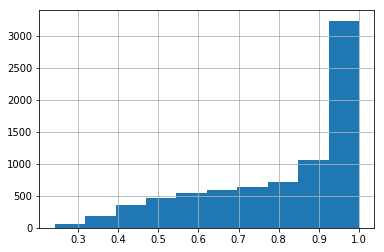

In [87]:
subdf.drop(columns=['object_id']).max(axis=1).hist()

In [ ]:
subdf.head().to_csv(index=False)

In [ ]:
%%time
subdf.to_csv(
        os.path.join('../results', filename + '_raw_proba.csv'), index=False)git 